In [1]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3
#%env PYTHONHASHSEED=0#important command to get reproducible results of D from cut traj using trackpy 5.0, but slows down code

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pims
import scipy as sp
from scipy import signal

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# tweak styles.
mpl.rc('figure',  figsize=(10, 6))
mpl.rc('image', cmap='red')

from ipyparallel import Client
client = Client()
view = client.load_balanced_view()
import trackpy as tp
tp.quiet()

In [2]:
%%px
import trackpy as tp

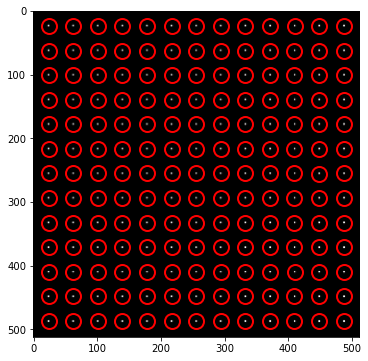

"\nfig, ax = plt.subplots()\nax.hist(f['mass'], bins=20)\nax.set(xlabel='mass', ylabel='count');\n#shows bias\nplt.figure()\ntp.subpx_bias(tp.locate(frames[:], 9, minmass=1000));\n"

In [27]:
#save your movie as tiff using Imagej before opening it here!
path = 'trackpy_testing/0p8_2k_trackpy2'
name = '0p8_2k_trackpy2'
frames = pims.TiffStack(path + '.tif', as_grey=True)#opens the tiffstack of movie frames
frames#gives you info about pixels and frames
# make a preview figure of a frame's particles detected
f = tp.locate(frames[0], 7, minmass=800)
plt.figure()  
tp.annotate(f, frames[0]);
'''
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=20)
ax.set(xlabel='mass', ylabel='count');
#shows bias
plt.figure()
tp.subpx_bias(tp.locate(frames[:], 9, minmass=1000));
'''

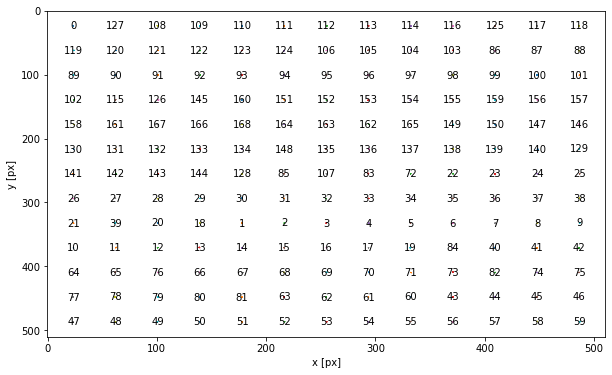

Before: 169 After: 169


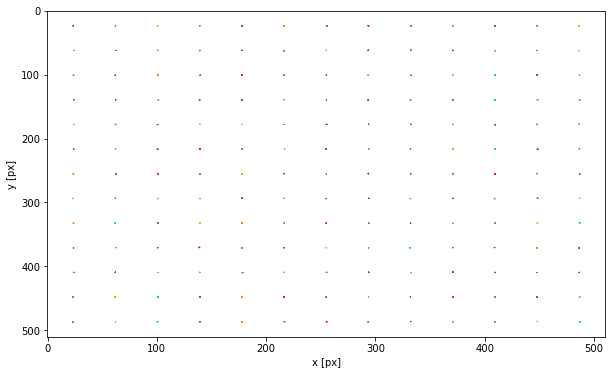

In [34]:
frames_preload = list(frames[:])
# tp.batch, which calls tp.locate on each frame and collects the results
#f = tp.batch(frames_preload[:1998], 7, minmass=29000, max_iterations=1, characterize=False, processes="auto");
f = tp.batch(frames_preload[:1998], 5, minmass=10, characterize=False, processes="auto");#radius is always an odd number
#implementats Crocker-Grier linking algorithmto link trajectories, needs to specify a maximum displacement between adjacent frames
#Memory keeps track of disappeared particles and maintains their ID for up to some number of frames after their last appearance
t = tp.link_df(f, 5, memory=5)
t.head()
plt.figure()
tp.plot_traj(t, label=True, superimpose=None);
# Compare the number of particles in the unfiltered and filtered data 
# that last for a given number of frames.
t1 = tp.filter_stubs(t, 5)
print('Before:', t['particle'].nunique(),'After:', t1['particle'].nunique())
#Compute xy drift and remove drift
drft = tp.compute_drift(t1)
tm = tp.subtract_drift(t1.copy(), drft)
plt.figure()
ax = tp.plot_traj(tm)

In [38]:
t = tp.link_df(f, 4, memory=4)
# Compare the number of particles in the unfiltered and filtered data 
# that last for a given number of frames.
t1 = tp.filter_stubs(t, 5)
print('Before:', t['particle'].nunique(),'After:', t1['particle'].nunique())
print(type(t1))

Before: 169 After: 169
<class 'pandas.core.frame.DataFrame'>


In [ ]:
'''If you would like to use HD5 format:

#PandasHDFStore -- fastest for a small (~100) number of frames
#PandasHDFStoreBig -- fastest for a medium or large number of frames
#PandasHDFStoreSingleNode -- optimizes HDF queries that access multiple frames (advanced)
with tp.PandasHDFStoreSingleNode('data.h5') as s:
    tp.batch(frames_preload[:1998], 7, minmass=60, characterize=False, processes="auto", output=s)
    all_results = s.dump()    
with tp.PandasHDFStore('data.h5') as s:
    # As before, we require a minimum "life" of 5 frames and a memory of 4 frames
    for linked in tp.link_df_iter(s, 2, memory=2):
        s.put(linked)
    # get results by frame with s.get(frame_number) or, when you have sufficient memory, retrieve them all
    trajectories = pd.concat(iter(s))
trajectories.head()
'''
'''
#adaptive search; refer to tutorial on Adaptive Search on trackpy website
tracks_adaptive = tp.link_df(f, 0.95, adaptive_stop=0.56, adaptive_step=0.99)
tracks_adaptive.groupby('particle').particle.count().value_counts()
plt.figure()
ax = tp.plot_traj(tracks_adaptive)'''

In [35]:
#Stepsize Calculation by frame; inspiration from Han's stepsize code
i=0
j=1
stepsize_list = [] 
for i in range(len(frames_preload)-2):
    mtn = tp.motion.relate_frames(t1, i, j)#Find the displacement vector of all particles between two frames
    step = (np.sqrt((mtn.dx)**2 + (mtn.dy)**2))*(254)
    i = i+1
    j = j+1
    stepsize_list.append(float(step[0]))
print(r'The median stepsize is {0:.10f} nm'.format(np.median(stepsize_list)))

The median stepsize is 11.4151139721 nm


C:\Users\Talha\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Talha\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


[15.4649041   7.54747478  6.28305129  5.40228549 11.55374924 11.05777765
  9.44980923  7.60161942 15.94656655  6.96939871  9.93511421 13.26930466
 15.62092934 15.82458043  6.13403932 12.12037574  8.30859932  9.10860027
  5.73019902  6.25031107  8.0666223  13.76653984  7.94594349 21.28155177
  9.52658531  6.7379022  15.00166872 12.98882206  6.53772685  9.60466742
 11.46411079 14.61135435  7.37741874 10.33246204  6.74905745  7.38984741
  8.89430927 16.96444021 13.61304011  9.13122198 12.32799152  9.01782393
 19.66539811  7.13913654  6.60434141 13.02389768  6.60184936  8.48641035
  7.83160036 19.12635204 23.17408036  7.53096716 15.14522838  8.90103033
 14.29437988  8.70384513 10.59409286 13.38562878  8.62699557  6.95493965
 11.60301434  5.67231632 10.38192279 13.51763812 13.28159163  7.40051349
 11.37816453 12.96837943 21.42855271 17.21995838  8.93441382 10.99838078
  4.97161702  9.76324161 10.75117374 12.54438055 12.29923287 10.9727553
 13.45571187  9.12787211 14.4370912  12.19551833 14.

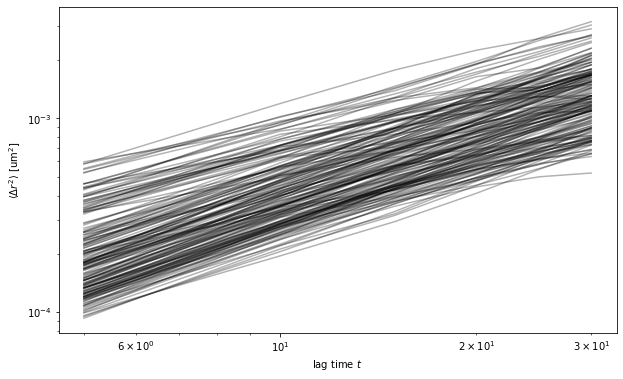

In [36]:
#Compute the mean squared displacement of each particle
im = tp.imsd(t1, 0.254, 0.2, max_lagtime=6)  # microns per pixel = 0.254, frames per second = 0.2, D calculated from first 6 pts
slope = np.linalg.lstsq(im.index[:, np.newaxis], im)[0][0]
D = (slope/4)*(10**6) #calculates D for every molecule
#print(D)
D.sort() #calculates the median D
print(D)
med = np.median(D)
print(r'The median diffusion coefficient is {0:.3f} nm²/s'.format(med))
fig, ax = plt.subplots()
ax.plot(im.index, im, 'k-', alpha=0.3)  # black lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [um$^2$]',
       xlabel='lag time $t$')
ax.set_xscale('log')
ax.set_yscale('log')

np.savetxt(name +'D.csv', D, delimiter=',', comments="")
#ax.set(xlim=(0, 16), ylim=(0, 20))

In [ ]:
#To analyze each trajectory and get the information as the velocity and mean velocity for ploting 
#the histogram and see the distrubtion of th mean velocity.
data = pd.DataFrame()
Fps = 0.2 #set the Number of frame per second at the video was recording.
for item in set(tm.particle):
    sub = tm[tm.particle==item]
    dx = np.diff(sub.x)/1. #we calculate the differnece between to frame for X postion
    dy = np.diff(sub.y)/1. #we calculate the differnece between to frame for Y postion
    dt = np.diff(sub.frame)/Fps #to calculate the time
    v = ((np.sqrt(dy**2 + dx**2)))/dt # to calcul the velocity
    for x, y, dx, dy, v, dt, frame in zip(sub.x[:-1], sub.y[:-1], abs(dx), abs(dy), v, dt,sub.frame
[:-1],):
        data = data.append([{'dx': dx,
        'dy': dy,
        'x': x,
        'y': y,
        'frame': frame,
        'particle': item,
        'dt' : dt,
        'v' : v,
        }])

#Translate DataFrame to nested_dictionary because it's easy to manipulate the Data we get.
mydict = {}
for p in np.unique(data.particle):
    d = {}
    d['v'] = data.v[data.particle == p]
    d['frame'] = data.frame[data.particle == p]
    d['x'] = data.x[data.particle == p]
    d['y'] = data.y[data.particle == p]
    d['dx'] = data.dx[data.particle == p]
    d['dy'] = data.dy[data.particle == p]
    d['dt'] = data.dt[data.particle == p]
    mydict[p] = d

#plot velocities of each particle
for p in mydict.keys():
    v_p = mydict[p]['v']
    frame_p = mydict[p]['frame']
    t_p = frame_p/Fps
    dt = mydict[p]['dt']
    plt.plot(t_p, v_p)
plt.xlabel('time [s]')
plt.ylabel(r'velocity [um/s]')
plt.show()
#velocity profile for each particle w.r.t. time
mean_v = []
for p in mydict.keys():
    v_p = mydict[p]['v']
    frame_p = mydict[p]['frame']
    t_p = frame_p/Fps
    #the array is filtered with uniform filter of given size.
    v_p_filtered = sp.ndimage.filters.uniform_filter1d(v_p, size = 20)
    mean_v.append(np.mean(v_p_filtered)) #add each mean velocity of each particle to list mean_v
    plt.plot(t_p, v_p_filtered, label=p)
plt.legend(bbox_to_anchor=(1.2, 1.))
plt.xlabel('time [s]')
plt.ylabel(r'velocity [um/s]')
plt.show()

#To write in a text file the data we get
for i in [0]: #Don't forget to updat the number between [] for each video :-)
    np. savetxt ('path.txt'.format(i), mean_v)
#To plot the histogram with the percentage
fig, ax = plt.subplots(figsize=(14,10))
hist, bins = np.histogram(mean_v, bins = [0, 0.010, 0.015, 0.020, 0.025, 0.030, 0.035, 0.040, 0.045, 0.050])
ax.bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]), color='Blue', label
= 'Particles' )
plt.legend()
plt.ylabel('Frequency')
plt.xlabel(r'velocity [um/s]')
plt.title('Histogram of particles')
plt.show()

In [ ]:
'''
#Compute the ensemble mean squared displacements of many particles
em = tp.emsd(t1, 0.254, 0.2,  max_lagtime=6)
fig, ax = plt.subplots()
ax.plot(em.index, em, 'o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [nm$^2$]',
       xlabel='lag time $t$')
slope = np.linalg.lstsq(em.index[:, np.newaxis], em)[0][0]
ax = em.plot(style='o', label='MSD in 2D')
ax.plot(np.arange(20), slope * np.arange(20), label='linear fit')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [[$\mu$m$^2$]', xlabel='lag time $t$')
#ax.set(xlim=(0, 10000), ylim=(0, 20000))
ax.legend(loc='upper right')
D = (slope/4)*(10**6) #calculate D and convert it from um^2/s to nm^2/s
print(r'The diffusion constant is {0:.2f} nm²/s'.format(D))
'''